<a href="https://colab.research.google.com/github/AlexTako/AI_practice/blob/main/AI_music.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Решеные задачи:**

1. Использовал [датасет](https://storage.yandexcloud.net/academy.ai/classical-music-midi.zip) произведений классической музыки, обучил модель "сочинять" музыку.
2. В качестве начальной последовательности для генерации использовал произведения Моцарта.


In [ ]:
!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth
!pip install --upgrade music21

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fluidsynth is already the newest version (2.2.5-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
!add-apt-repository ppa:mscore-ubuntu/mscore-stable -y
!apt-get update
!apt-get install musescore

Repository: 'deb https://ppa.launchpadcontent.net/mscore-ubuntu/mscore-stable/ubuntu/ jammy main'
Description:
~~~~~~~~~ MUSESCORE 2 RELEASES FOR UBUNTU 12.04 AND LATER ~~~~~~~~~
Note that Canonical doesn’t allow new builds for releases marked obsolete
(any nōn-LTS predating the previous LTS (currently 24.04 “noble”), and any LTS
older than 7 years, currently anything before 14.04 “trusty”). The packages
for those older releases here can no longer be updated but still work, within
limitations. Best to upgrade to a supported release of the operating system!

INSTALLING: (run these commands from the terminal)
  sudo add-apt-repository ppa:mscore-ubuntu/mscore-stable
  sudo apt-get update
  sudo apt-get install musescore

DO *NOT* USE THESE PPAs on Debian, only on Ubuntu!

‣‣‣ These packages are NOT suitable for ”KDE neon 18.04 (bionic)”!
‣ Use https://build.opensuse.org/project/show/home:mirabile:mscore instead.
⚠ KDE neon 18.04 was discontinued so those packages can no longer be updated

In [ ]:
!apt-get install xvfb

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.10).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
from music21 import *

# настраиваем окружение в соответствии с документацией
us = environment.UserSettings()
us['musescoreDirectPNGPath'] = '/usr/bin/mscore'
us['directoryScratch'] = '/tmp'

In [ ]:
# Импортируем библиотеки
import tensorflow
import os
import numpy as np
import pandas as pd
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import *
import fluidsynth

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import keras.backend as K
from keras.optimizers import Adamax

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

import sys
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/classical-music-midi.zip

--2024-05-01 07:39:01--  https://storage.yandexcloud.net/academy.ai/classical-music-midi.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2751606 (2.6M) [application/x-zip-compressed]
Saving to: ‘classical-music-midi.zip.1’

classical-music-mid 100%[===================>]   2.62M  2.50MB/s    in 1.0s    

2024-05-01 07:39:02 (2.50 MB/s) - ‘classical-music-midi.zip.1’ saved [2751606/2751606]



In [ ]:
# Разархивируем датасета во временную папку 'dataset'
!unzip -qo "classical-music-midi" -d ./dataset

In [ ]:
!dir ./dataset

Albeniz    Borodin	Christmas  Granados  Mendelssohn  Rachmaninoff	Sinding
Bach	   Brahms	Clementi   Grieg     Moszkowski   Ravel		Tchaikovsky
Balakirev  Burgmueller	Debussy    Haydn     Mozart	  Schubert
Beethoven  Chopin	Godowsky   Liszt     Mussorgsky   Schumann


In [ ]:
CLASS_LIST=["Chopin"]

In [ ]:
all_midis = []
for compositor in CLASS_LIST:
    filepath = f"./dataset/{compositor}/"
    for i in os.listdir(filepath):
        if i.endswith(".mid"):
            tr = filepath+i
            # чтение и парсинг midi-файлов в Stream-объект библиотеки music21
            midi = converter.parse(tr)
            if compositor == "Chopin":
                all_midis.append(midi)

In [ ]:
# установим библиотеку для извлечения данных из MIDI
!pip install pretty_midi

In [ ]:
# импортируем необходимые библиотеки

# для работы с матрицами
import numpy as np

# для работы с датафреймами
import pandas as pd

# импортируем загруженную библиотеку для работы с MIDI
import pretty_midi

In [ ]:
import json
from music21 import note, chord, instrument

"""def getNotes(file):

    Функция извлекает информацию о нотах из файла MIDI.

    Parameters:
    file: файл MIDI для анализа.

    Returns:
    list: Список JSON-строк, представляющих информацию о нотах в формате (midi_pitch, step, duration).

    notes = []  # Список для хранения информации о нотах
    notes_to_parse = None  # Переменная для хранения извлеченных нот
    step = 0  # Переменная для отслеживания текущего временного шага

    # Проход через каждую часть (инструмент) в файле MIDI
    for j in file:
        # Разбиение на отдельные инструменты, если это возможно
        songs = instrument.partitionByInstrument(j)

        # Проход через каждую часть инструмента
        for part in songs.parts:
            # Извлечение всех нот для каждой части инструмента
            notes_to_parse = part.recurse()

            # Проход через каждый элемент в извлеченных нотах
            for element in notes_to_parse:
                # Если элемент является отдельной нотой (а не аккордом)
                if isinstance(element, note.Note):
                    # Извлечение информации о ноте и добавление ее в список notes
                    notes.append(json.dumps((element.pitch.midi, element.step, float(element.duration.quarterLength))))
                    # Обновление переменной step
                    step += float(element.duration.quarterLength)

                # Если элемент является аккордом
                elif isinstance(element, chord.Chord):
                    # Проход через каждую ноту в аккорде
                    for n in element:
                        # Извлечение информации о ноте и добавление ее в список notes
                        notes.append(json.dumps((n.pitch.midi, n.step, float(n.duration.quarterLength))))
                    # Обновление переменной step
                    step += float(element.duration.quarterLength)

    return notes  # Возвращение списка notes"""

'def getNotes(file):\n    \n    Функция извлекает информацию о нотах из файла MIDI.\n\n    Parameters:\n    file: файл MIDI для анализа.\n\n    Returns:\n    list: Список JSON-строк, представляющих информацию о нотах в формате (midi_pitch, step, duration).\n    \n    notes = []  # Список для хранения информации о нотах\n    notes_to_parse = None  # Переменная для хранения извлеченных нот\n    step = 0  # Переменная для отслеживания текущего временного шага\n\n    # Проход через каждую часть (инструмент) в файле MIDI\n    for j in file:\n        # Разбиение на отдельные инструменты, если это возможно\n        songs = instrument.partitionByInstrument(j)\n\n        # Проход через каждую часть инструмента\n        for part in songs.parts:\n            # Извлечение всех нот для каждой части инструмента\n            notes_to_parse = part.recurse()\n\n            # Проход через каждый элемент в извлеченных нотах\n            for element in notes_to_parse:\n                # Если элемент являе

In [ ]:
# Функция преобразования миди-файлов в ноты
def getNotes(file):
    notes = []
    notes_to_parse = None
    for j in file:

        # получение инструментов из Stream-объекта
        songs = instrument.partitionByInstrument(j)

        # цикл по всем инструментам
        for part in songs.parts:
            # используем рекурсивный итератор в соответствии с документацией
            notes_to_parse = part.recurse()
            # части Stream-объекта, с которым мы работает состоит из разных элементов
            # отберем только интересующие нас элементы note.Note (нота) и chord.Chord (целый аккорд, последовательность нот)
            for element in notes_to_parse:
                if isinstance(element, note.Note):
                    # извлекаем ноту как тон (терминология библиотеки)
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    # аккорд функционирует как объект-нота, но имеет несколько последовательных тонов
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes

In [ ]:
Corpus = getNotes(all_midis)
print("Всего нот во всех midi-файлах всего датасета:", len(Corpus))

Всего нот во всех midi-файлах всего датасета: 57894


In [ ]:
print(Corpus)

['0.3.7', '0', '8.0.3', '5', '3.7.11', '7', '2.5', '0.3.7', '7.0', '8.0.3', '8', '1.5.8', '1', '0.1.3.7', '3', '10.1', '8.0.3', '8', '11.2.5', '7', '4.7.10.0', '0', '7.8.0', '5', 'F4', '0.3.7', '0', '0.2.6', '9.2', '7.11.2', '7', '11.0.2.6', '2', 'A4', '7.11.2', '7', '3.7', '0', '3.8', '0', '2.8', '11', 'F#4', '2.7', '10', '7.0', '9', '0.2.6', '8', '7.11.2', '7', '9.0', '7.11.2', '5', '7.0', '3', '8.0', '5', '2.7', '11', 'F4', '0.3.7', '0', '8.0.3', '8', '1.5.8', '1', '3.5.7.11', '7', 'D4', '0.3.7', '0', '3.7', '0', '3.8', '0', '2.8', '11', 'F#4', '2.7', '10', '7.0', '9', '0.2.6', '8', '7.11.2', '7', '9.0', '7.11.2', '5', '7.0', '3', '8.0', '5', '2.7', '11', 'F4', '0.3.7', '0', '8.0.3', '8', '1.5.8', '1', '3.5.7.11', '7', 'D4', '0.3.7', '0', '0.3.7', '7.0', 'B-4', 'B-4', 'E-2', 'B-3', 'G3', 'G4', 'B-2', 'E-5', 'E-2', 'E-4', 'G3', 'B-4', 'B-2', 'G5', 'E-2', 'G4', 'B-3', 'E-5', 'B-2', 'B-5', 'E-2', 'B-4', 'E-4', 'G5', 'G3', 'E-6', 'B-2', 'E-5', 'G4', 'B-5', 'B-3', 'G6', 'E-3', 'G5', 'B-4

In [ ]:
# Функция преобразования отрывка из корпуса обратно в поток
def chords_n_notes(chunk):
    Melody = []
    offset = 0 # счетчик
    for i in chunk:
        # Если это аккорд разделенный точкой
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") # Разделяем аккорд на части
            notes = []
            for j in chord_notes:
                inst_note=int(j)
                # Преобразуем ноту в обект Note (нота)
                note_chunk = note.Note(inst_note)
                notes.append(note_chunk)
                # объединяем ноты в аккорды
                chord_chunk = chord.Chord(notes)
                # задаем позицию аккорда
                chord_chunk.offset = offset
                Melody.append(chord_chunk)
        # если это нота, а не аккорд
        else:
            # из текстового обозначения ноты делаем объект Note (ноту)
            note_chunk = note.Note(i)
            # задаем позицию ноты
            note_chunk.offset = offset
            Melody.append(note_chunk)
        # увеличиваем номер позиции
        offset += 1


    return Melody

In [ ]:
from collections import Counter
count_num = Counter(Corpus)
print("Общее число уникальных нот в корпусе:", len(count_num))

Общее число уникальных нот в корпусе: 397


In [ ]:
# Ключ в словаре - имена нот
# Значение в словаре - их количество

Notes = list(count_num.keys())
Recurrence = list(count_num.values())

# Средняя частота встречаемости нот в корпусе
def Average(rec):
    return sum(rec) / len(rec)

print('Средняя повторяемость ноты:', Average(Recurrence))
print('Наиболее часто встречаемые ноты:', max(Recurrence), 'раз')
print('Наиболее редкие ноты:', min(Recurrence), 'раз')

Средняя повторяемость ноты: 145.8287153652393
Наиболее часто встречаемые ноты: 1627 раз
Наиболее редкие ноты: 1 раз


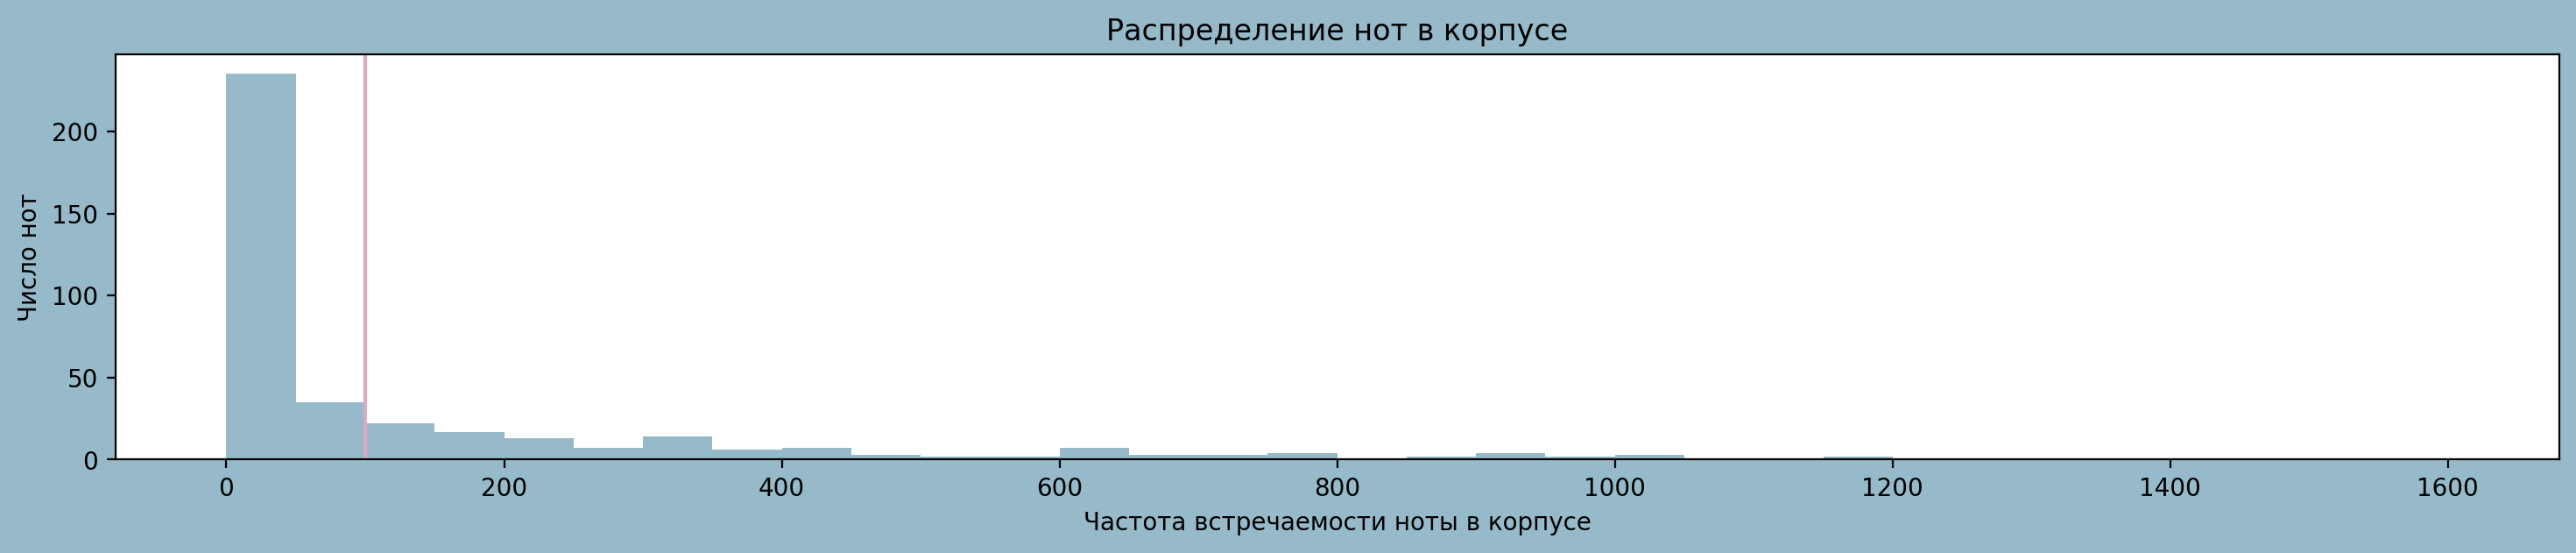

In [ ]:
plt.figure(figsize=(18, 3), facecolor='#97BACB')
bins = np.arange(0,(max(Recurrence)), 50)
plt.hist(Recurrence, bins=bins, color='#97BACB')
plt.axvline(x=100, color='#DBACC1') # отсечка по встречаемости в 100 раз
plt.title('Распределение нот в корпусе')
plt.xlabel('Частота встречаемости ноты в корпусе')
plt.ylabel('Число нот')
plt.show()

In [ ]:
# Получение списка редких нот
def get_rare_note(count_num):
    """
    Функция возвращает список редких нот в зависимости от их количества в корпусе.

    Parameters:
    count_num (Counter): Счетчик уникальных нот в корпусе.

    Returns:
    list: Список редких нот.
    """
    rare_note = []
    for index, (key, value) in enumerate(count_num.items()):
        if value < 150:
            m =  key
            rare_note.append(m)
    return rare_note

Chopin_rare_note = get_rare_note(count_num)
print(f"Общее число нот, которые повторяются менее 150 раз: {len(Chopin_rare_note)}")

Общее число нот, которые повторяются менее 150 раз: 292


In [ ]:
def del_Corpus(Corpus, rare_note):
    """
    Функция удаляет редкие элементы из списка Corpus.

    Parameters:
    Corpus (list): Исходный список.
    rare_note (list): Список редких элементов для удаления.

    Returns:
    list: Измененный список Corpus без редких элементов.
    """
    # Проходим по каждому элементу в исходном списке
    for element in Corpus:
        # Если текущий элемент находится в списке редких элементов
        if element in rare_note:
            # Удаляем текущий элемент из исходного списка
            Corpus.remove(element)
    return Corpus

Chopin_Corpus = del_Corpus(Corpus, Chopin_rare_note)

print(f"Длина корпуса после исключения редких нот у Шопена - {len(Chopin_Corpus)}")

Длина корпуса после исключения редких нот у Шопена - 51672


In [ ]:
def det_L_corpus_L_symb_mapping(Corpus):
    """
    Функция определяет длину корпуса, количество уникальных символов в корпусе и создает отображения символов.

    Parameters:
    Corpus (list): Список нот в корпусе.

    Returns:
    tuple: Кортеж содержащий список уникальных символов, длину корпуса, количество уникальных символов,
    отображение символов в индексы и отображение индексов в символы.
    """
    # Сохраняем все уникальные значения корпуса
    symb = sorted(list(set(Corpus)))

    L_corpus = len(Corpus) # длина корпуса
    L_symb = len(symb) # число уникальных элементов корпуса

    # Создание словаря для доступа к словарному запасу из индексов и наоборот
    mapping = dict((c, i) for i, c in enumerate(symb))
    reverse_mapping = dict((i, c) for i, c in enumerate(symb))
    return symb, L_corpus, L_symb, mapping, reverse_mapping

Chopin_symb, Chopin_L_corpus, Chopin_L_symb, Chopin_mapping, Chopin_reverse_mapping = det_L_corpus_L_symb_mapping(Chopin_Corpus)
print("Общее число символов у Шопена -", Chopin_L_corpus)
print("Число уникальных символов у Шопена -", Chopin_L_symb)

Общее число символов у Шопена - 51672
Число уникальных символов у Шопена - 270


In [ ]:
# Разбиение корпуса на равные входные строки и выходные целевые последовательности

length = 40    # длинны последовательностей

def get_feature_target(Corpus, L_corpus, mapping, length=length):
    features = []    # входные последовательности
    targets = []    # целевые последовательности
    # цикл разбиения корпуса
    for i in range(0, L_corpus - length, 1):
        feature = Corpus[i:i + length]
        target = Corpus[i + length]
        features.append([mapping[j] for j in feature])
        targets.append(mapping[target])
    return features, targets
Chopin_features, Chopin_targets = get_feature_target(Chopin_Corpus, Chopin_L_corpus, Chopin_mapping)

Chopin_L_datapoints = len(Chopin_targets)

print("Общее количество последовательностей в корпусе у Шопена -", Chopin_L_datapoints)

Общее количество последовательностей в корпусе у Шопена - 51632


In [ ]:
def get_x_y(L_datapoints, L_symb, features, targets, length=length):
    # изменение размера и нормализация входных данных
    X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)

    # one-hot encode для целевых выходных данных
    y = tensorflow.keras.utils.to_categorical(targets)
    return X, y

X, y = get_x_y(Chopin_L_datapoints, Chopin_L_symb, Chopin_features, Chopin_targets)

In [ ]:
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(f'Форма входных данных: {X_train.shape}')
print(f'Форма выходных данных: {y_train.shape}')

Форма входных данных: (41305, 40, 1)
Форма выходных данных: (41305, 270)


In [ ]:
random_state = 42 # для воспроизводимости

# Установим воспроизводимость для генератора случайных чисел
np.random.seed(random_state)

# Генерируем случайные индексы для перемешивания
train_indices = np.random.permutation(int(Chopin_L_datapoints*0.2))

# Применяем случайный порядок к данным
X_train = X_train[train_indices]
y_train = y_train[train_indices]

In [ ]:
# Архитектура НС
model = Sequential()

model.add(LSTM(256, input_shape=X_train.shape[1:], return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(128))
model.add(Dense(128))
model.add(Dropout(0.1))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 40, 256)           264192    
                                                                 
 dropout_2 (Dropout)         (None, 40, 256)           0         
                                                                 
 lstm_3 (LSTM)               (None, 128)               197120    
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 270)               34830     
                                                                 
Total params: 512654 (1.96 MB)
Trainable params: 51265

In [ ]:
# Обучение
history = model.fit(X_train, y_train, batch_size=256, epochs=150)

Epoch 1/150
41/41 [==============================] - 6s 20ms/step - loss: 4.8554 - acc: 0.0250
Epoch 2/150
41/41 [==============================] - 1s 18ms/step - loss: 4.6329 - acc: 0.0219
Epoch 3/150
41/41 [==============================] - 1s 18ms/step - loss: 4.6224 - acc: 0.0280
Epoch 4/150
41/41 [==============================] - 1s 17ms/step - loss: 4.6147 - acc: 0.0245
Epoch 5/150
41/41 [==============================] - 1s 18ms/step - loss: 4.6105 - acc: 0.0246
Epoch 6/150
41/41 [==============================] - 1s 18ms/step - loss: 4.5979 - acc: 0.0296
Epoch 7/150
41/41 [==============================] - 1s 18ms/step - loss: 4.5446 - acc: 0.0273
Epoch 8/150
41/41 [==============================] - 1s 18ms/step - loss: 4.6209 - acc: 0.0225
Epoch 9/150
41/41 [==============================] - 1s 18ms/step - loss: 4.5953 - acc: 0.0248
Epoch 10/150
41/41 [==============================] - 1s 18ms/step - loss: 4.5868 - acc: 0.0234
Epoch 11/150
41/41 [=============================

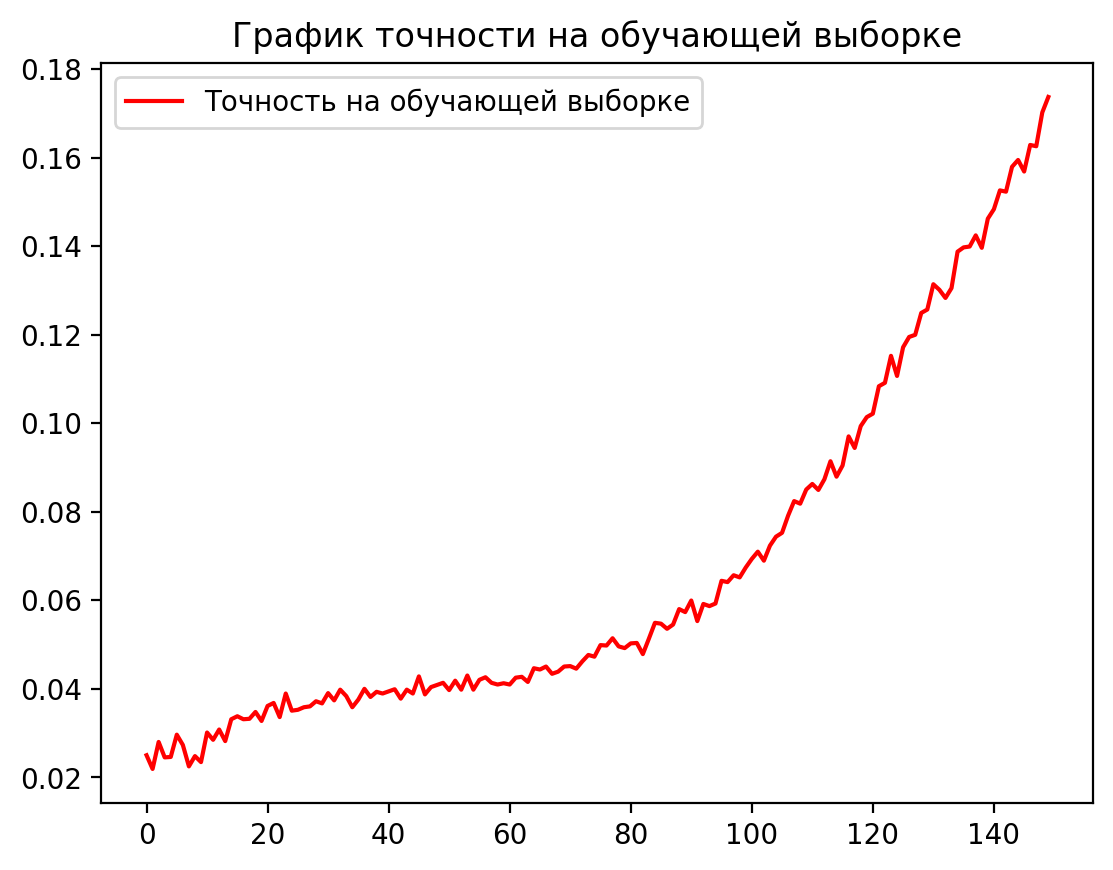

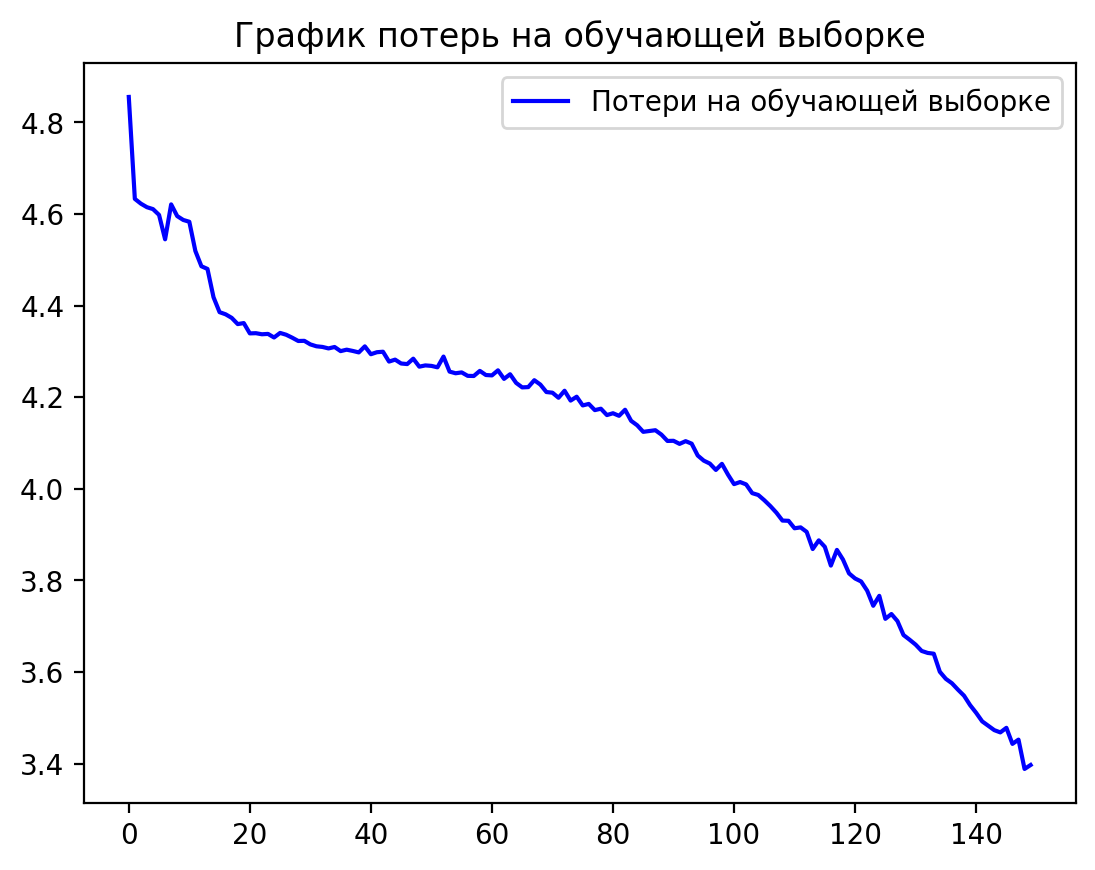

In [ ]:
# Оценка результатов обучения
plt.plot(history.epoch, history.history['acc'], 'r', label='Точность на обучающей выборке')
plt.title('График точности на обучающей выборке')
plt.legend()
plt.figure()
plt.plot(history.epoch, history.history['loss'], 'b', label='Потери на обучающей выборке')
plt.title('График потерь на обучающей выборке')
plt.legend()
plt.show()

In [ ]:
temperature = 1 # В генерации музыки явно не нужен самый точный результат, поэтому возьмем побольше

def music_generator(seq_len):
    # случайный выбор начальной последовательности
    seed = X_seed[np.random.randint(0, len(X_seed)-1)]
    music = []
    notes = []
    for i in range(seq_len):
        # изменяем размер данных для передачи модели
        seed = seed.reshape(1, length, 1)

        # предсказываем по начальной последовательности
        prediction = model.predict(seed, verbose=0)[0]

        # предсказанные значения прогоняем через функцию softmax
        exp_preds = np.exp(prediction/temperature)
        prediction = exp_preds / np.sum(exp_preds/temperature)

        # выбираем индекс наиболее вероятного класса
        index = np.argmax(prediction)

        # нормализованный индекс в интервале [0, 1]
        # значение пойдет в seed, а там все значения в интервале [0, 1]
        index_N = index / float(Chopin_L_symb)

        # складываем в список индекс предсказанной ноты
        notes.append(index)

        # обратное преобразование по словарю, на выходе последовательность нот
        music = [Chopin_reverse_mapping[char] for char in notes]

        # seed всегда длины length
        # добавляем справа новое значение, а слева удаляем и уходим на новую итерацию цикла
        seed = np.insert(seed[0], len(seed[0]), index_N)
        seed = seed[1:]

    return chords_n_notes(music)

In [ ]:
genMusic = music_generator(100)
genMidi = stream.Stream(genMusic)

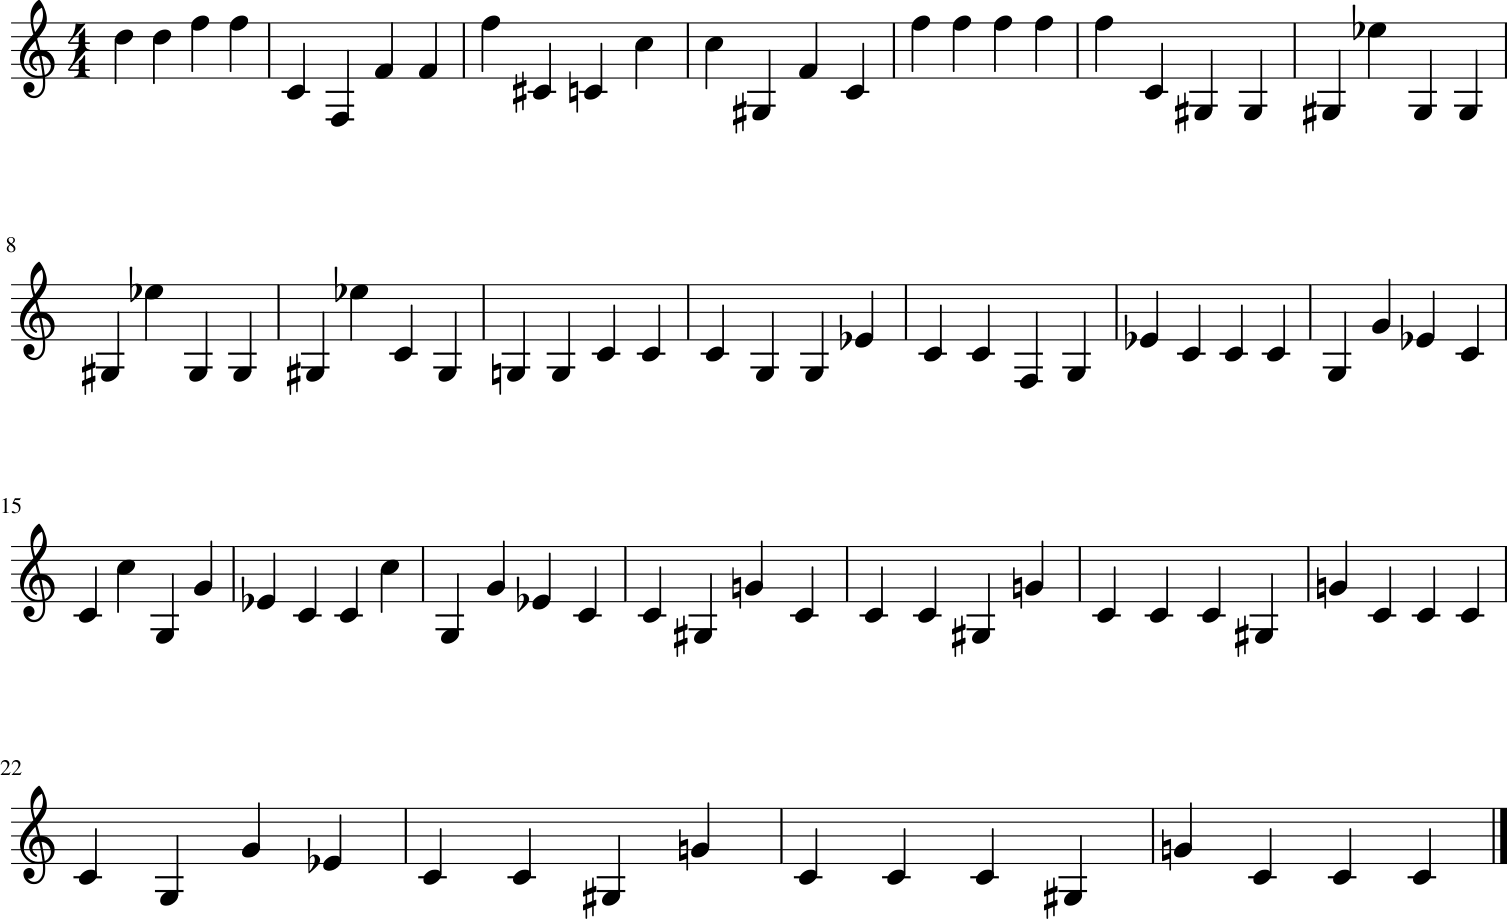

In [ ]:
genMidi.show()

In [ ]:
# Выведем в виде звуковой дорожки
genMidi.show('midi')